In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /content/input
!mkdir /content/input/data-path
!mkdir /content/input/training-data
!mkdir /content/working

In [5]:
!cp /content/drive/MyDrive/DLCourse/Lab3/Path_to_train.csv /content/input/data-path
!cp /content/drive/MyDrive/DLCourse/Lab3/Path_to_valid.csv /content/input/data-path
!cp /content/drive/MyDrive/DLCourse/Lab3/Path_to_test.csv /content/input/data-path
!cp /content/drive/MyDrive/DLCourse/Lab3/training_data.zip /content
# !cp /content/drive/MyDrive/DLCourse/Lab3/debug_training_data.zip /content

In [6]:
!unzip training_data.zip -d /content/input/training-data

串流輸出內容已截斷至最後 5000 行。
  inflating: /content/input/training-data/training_data/UID_51_53_3_all.bmp  
  inflating: /content/input/training-data/training_data/UID_51_54_1_all.bmp  
  inflating: /content/input/training-data/training_data/UID_51_55_1_all.bmp  
  inflating: /content/input/training-data/training_data/UID_51_56_1_all.bmp  
  inflating: /content/input/training-data/training_data/UID_51_56_2_all.bmp  
  inflating: /content/input/training-data/training_data/UID_51_56_3_all.bmp  
  inflating: /content/input/training-data/training_data/UID_51_56_4_all.bmp  
  inflating: /content/input/training-data/training_data/UID_51_56_5_all.bmp  
  inflating: /content/input/training-data/training_data/UID_51_56_6_all.bmp  
  inflating: /content/input/training-data/training_data/UID_51_56_7_all.bmp  
  inflating: /content/input/training-data/training_data/UID_51_57_1_all.bmp  
  inflating: /content/input/training-data/training_data/UID_51_57_2_all.bmp  
  inflating: /content/input/training-data/t

In [ ]:
### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
import pandas as pd
from PIL import Image
from torch.utils import data
import numpy as np

def getData(mode):
    if mode == 'train':
        df = pd.read_csv('./input/data-path/Path_to_train.csv')
        path = df['Path'].tolist()
        label = df['label'].tolist()
        return path, label

    elif mode == "valid":
        df = pd.read_csv('./input/data-path/Path_to_valid.csv')
        path = df['Path'].tolist()
        label = df['label'].tolist()
        return path, label

    else:
        df = pd.read_csv('./input/data-path/Path_to_test.csv')
        path = df['Path'].tolist()
        label = df['label'].tolist()
        return path, label

class LeukemiaLoader(data.Dataset):
    def __init__(self, root, mode):
        self.root = root
        self.img_name, self.label = getData(mode)
        self.mode = mode
        print("> Found %d images..." % (len(self.img_name)))

    def __len__(self):
        return len(self.img_name)

    def __getitem__(self, index):
        img_p = Image.open(self.root+self.img_name[index])
        label = self.label[index]

        """
           step3. Transform the .jpeg rgb images during the training phase, such as resizing, random flipping,
                  rotation, cropping, normalization etc. But at the beginning, I suggest you follow the hints.

                  In the testing phase, if you have a normalization process during the training phase, you only need
                  to normalize the data.

                  hints : Convert the pixel value to [0, 1]
                          Transpose the image shape from [H, W, C] to [C, H, W]
        """
        img_r, img_g, img_b = img_p.split()
        img_r = np.array(img_r)
        img_g = np.array(img_g)
        img_b = np.array(img_b)

        img = []
        img.append(img_r/img_r.max())
        img.append(img_g/img_g.max())
        img.append(img_b/img_b.max())
        img = np.array(img)

        """
            step4. Return processed image and label
        """
        return img, label

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, kernel_size, stride, is_downsample=False):
        super(ResBlock, self).__init__()
        self.is_downsample = is_downsample

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=kernel_size, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=kernel_size, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu2 = nn.ReLU()
        if is_downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_c)
            )

    def forward(self, x):
        sample = x
        output = self.conv1(x)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.conv2(output)
        output = self.bn2(output)

        if self.is_downsample:
            sample = self.downsample(x)

        output += sample
        output = self.relu2(output)
        return output

class ResBottleneck(nn.Module):
    def __init__(self, previous_out, in_c, out_c, kernel_size, stride, is_downsample=False):
        super(ResBottleneck, self).__init__()
        self.is_downsample = is_downsample

        self.conv1 = nn.Conv2d(previous_out, in_c, kernel_size=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(in_c)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_c, in_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_c)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_c, out_c, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(out_c)
        self.relu3 = nn.ReLU()
        if is_downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(previous_out, out_c, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_c)
            )

    def forward(self, x):
        sample = x

        output = self.conv1(x)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.conv3(output)
        output = self.bn3(output)

        if self.is_downsample:
            sample = self.downsample(x)

        output += sample
        output = self.relu3(output)
        return output


class ResNet(nn.Module):
    def __init__(self, mode, block, in_channels, block_def):
        super(ResNet, self).__init__()
        self.mode = mode
        self._in = 64
        self._out = 64
        self.previous_out = self._out

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, self._out, kernel_size=7, stride=2),
            nn.BatchNorm2d(self._out),
            nn.ReLU()
        )

        self.maxPool = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2x = self.generate_block(block, block_def[0], 3, 1)
        self.conv3x = self.generate_block(block, block_def[1], 3, 2, True)
        self.conv4x = self.generate_block(block, block_def[2], 3, 2, True)
        self.conv5x = self.generate_block(block, block_def[3], 3, 2, True)
        self.avgPool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(self.previous_out, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxPool(x)

        x = self.conv2x(x)
        x = self.conv3x(x)
        x = self.conv4x(x)
        x = self.conv5x(x)
        x = self.avgPool(x)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def generate_block(self, block, layers, kernel_size=1, stride=1, downsample=False):
        layer = []
        is_downsample = downsample
        stride = stride

        match self.mode:
            case "18" | "34":
                for _ in range(layers):
                    layer.append(block(self._in, self._out, kernel_size, stride, is_downsample))
                    self._in = self._out
                    self.previous_out = self._out
                    if is_downsample:
                        is_downsample = False
                        stride = 1

                self._out *= 2
            case _:
                is_downsample = True
                self._out = self._in*4
                for _ in range(layers):
                    layer.append(block(self.previous_out, self._in, self._out, kernel_size, stride, is_downsample))
                    self.previous_out = self._out

                    if is_downsample:
                        is_downsample = False
                        stride = 1

                self._in *= 2

        return nn.Sequential(*layer)


In [9]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import gc
import seaborn as sn


def evaluate(valid_loader, model, max_acc=0.0, min_loss=10.0):
    device = hps["device"]
    crossEntropy = nn.CrossEntropyLoss()

    batch_valid_cost = []
    batch_valid_correct = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            features, labels = batch
            features = features.float().to(device)
            labels = labels.long().to(device)

            pred = model(features)
            loss = crossEntropy(pred, labels)

            batch_valid_cost.append(loss.item())
            batch_valid_correct.append((pred.argmax(dim=1) == labels).float().mean())

        valid_loss = sum(batch_valid_cost)/len(batch_valid_cost)
        valid_acc = sum(batch_valid_correct)/len(batch_valid_correct)

        history[hps["model"]+"_test_loss"].append(valid_loss)
        history[hps["model"]+"_test_acc"].append(valid_acc.item())

        print(f"validation loss = {valid_loss:5f}, validation acc = {valid_acc:.5f}")
        if valid_acc >= max_acc and valid_loss <= min_loss:
            save_model(model)
            return valid_acc, valid_loss
        else:
            return max_acc, min_loss


def test(test_loader, model):
    device = hps["device"]
    crossEntropy = nn.CrossEntropyLoss()

    batch_test_cost = []
    tp, tn, fp, fn = 0, 0, 0, 0

    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_loader):
            features, labels = batch
            features = features.float().to(device)
            labels = labels.long().to(device)

            preds = model(features)
            loss = crossEntropy(preds, labels)

            batch_test_cost.append(loss.item())
            for _, (pred, label) in enumerate(zip(preds.argmax(dim=1), labels)):
                if label == 0 and pred == 0: fp += 1
                elif label == 0 and pred == 1: fn += 1
                elif label == 1 and pred == 0: tn += 1
                else: tp += 1

        test_loss = sum(batch_test_cost)/len(batch_test_cost)
        test_acc = (tp+fp)/(fp+fn+tp+tn)
        confusion_mat = [[fp/(fp+fn), fn/(fp+fn)], [tn/(tp+tn), tp/(tp+tn)]]

        print(f"test loss = {test_loss:5f}, test acc = {test_acc:.5f}")
        plot_confusion_mat(confusion_mat)

def train(train_loader, valid_loader, model):
    device = hps["device"]
    n_epochs = hps["n_epochs"]
    optimizer = optim.Adam(model.parameters(), lr=hps["learning_rate"])
    crossEntropy = nn.CrossEntropyLoss()
    max_valid_acc = 0.0
    min_valid_loss = 10.0

    for epoch in range(n_epochs):
        batch_train_cost = []
        batch_train_correct = []

        model.train()

        for batch in tqdm(train_loader):
            features, labels = batch
            features = features.float().to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()

            pred = model(features)
            loss = crossEntropy(pred, labels)
            loss.backward()
            optimizer.step()

            batch_train_cost.append(loss.item())
            batch_train_correct.append((pred.argmax(dim=1) == labels).float().mean())

        epoch_loss = sum(batch_train_cost)/len(batch_train_cost)
        epoch_acc = sum(batch_train_correct)/len(batch_train_correct)
        history[hps["model"]+"_train_acc"].append(epoch_acc.item())
        history[hps["model"]+"_train_loss"].append(epoch_loss)

        print(f"[ Train | {epoch+1:02d}/{n_epochs:02d} ] loss = {epoch_loss:.5f}, acc = {epoch_acc:.5f}")
        max_valid_acc, min_valid_loss = evaluate(valid_loader, model, max_valid_acc, min_valid_loss)


def save_model(model):
    path = hps["save_path"]+hps["model"]+".pt"
    print("saving model...")
    torch.save(model.state_dict(), path)

def load_model(path, model):
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

def plot(data, n_epochs):
    epochs = [x for x in range(n_epochs)]
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy(%)")

    plt.plot(epochs, data["18_train_acc"], label="ResNet18 Train", marker=".")
    plt.plot(epochs, data["18_test_acc"], label="ResNet18 Test", marker=".")
    plt.plot(epochs, data["50_train_acc"], label="ResNet50 Train", marker=".")
    plt.plot(epochs, data["50_test_acc"], label="ResNet50 Test", marker=".")
    plt.plot(epochs, data["152_train_acc"], label="ResNet152 Train", marker=".")
    plt.plot(epochs, data["152_test_acc"], label="ResNet152 Test", marker=".")

    plt.legend()
    plt.show()


def plot_confusion_mat(confusion_mat):
    df = pd.DataFrame(confusion_mat, [0, 1], [0, 1])
    sn.heatmap(df, annot=True, cmap='Blues')


def save_result(csv_path, predict_result):
    df = pd.read_csv(csv_path)
    new_df = pd.DataFrame()
    new_df['ID'] = df['Path']
    new_df["label"] = predict_result
    new_df.to_csv("./your_student_id_resnet18.csv", index=False)

In [10]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda:0


In [11]:
# history
history = {"18_train_loss": [], "18_train_acc": [], "18_test_loss": [], "18_test_acc": [],
          "50_train_loss": [], "50_train_acc": [], "50_test_loss": [], "50_test_acc": [],
          "152_train_loss": [], "152_train_acc": [], "152_test_loss": [], "152_test_acc": []}

In [12]:
# hyperparameters
hps = {
    "learning_rate": 0.01,
    "n_epochs": 10,
    "batch_size": 8, # 128/8/4
    "model": "50", # "18"/"50"/"152"
    "block": ResBottleneck, # ResBlock/ResBottleneck/ResBottleneck
    "block_definition": [3, 4, 6, 3], # [2, 2, 2, 2]/[3, 4, 6, 3]/[3, 8, 36, 3]
    "device": device,
    "data_path": "./input/training-data/training_data/",
    "save_path": "./working/res"
}

In [13]:
train_loader = DataLoader(LeukemiaLoader(hps["data_path"], "train"), batch_size=hps["batch_size"], shuffle=True)
valid_loader = DataLoader(LeukemiaLoader(hps["data_path"], "valid"), batch_size=hps["batch_size"], shuffle=False)
in_channels = 3
res = ResNet(hps["model"], hps["block"], in_channels, hps["block_definition"]).to(device)
gc.collect()

> Found 7995 images...
> Found 1599 images...


12

In [14]:
# print(res)
train(train_loader, valid_loader, res)

100%|██████████| 1000/1000 [06:37<00:00,  2.52it/s]


[ Train | 01/10 ] loss = 0.59677, acc = 0.72475


100%|██████████| 200/200 [00:37<00:00,  5.40it/s]


validation loss = 0.515114, validation acc = 0.74616
saving model...


100%|██████████| 1000/1000 [06:21<00:00,  2.62it/s]


[ Train | 02/10 ] loss = 0.49220, acc = 0.78038


100%|██████████| 200/200 [00:36<00:00,  5.42it/s]


validation loss = 0.508382, validation acc = 0.75741
saving model...


100%|██████████| 1000/1000 [06:10<00:00,  2.70it/s]


[ Train | 03/10 ] loss = 0.49091, acc = 0.78171


100%|██████████| 200/200 [00:32<00:00,  6.11it/s]


validation loss = 0.472609, validation acc = 0.79688
saving model...


100%|██████████| 1000/1000 [06:07<00:00,  2.72it/s]


[ Train | 04/10 ] loss = 0.48352, acc = 0.78771


100%|██████████| 200/200 [00:33<00:00,  5.96it/s]


validation loss = 0.478650, validation acc = 0.77929


100%|██████████| 1000/1000 [06:07<00:00,  2.72it/s]


[ Train | 05/10 ] loss = 0.48154, acc = 0.79088


100%|██████████| 200/200 [00:32<00:00,  6.10it/s]


validation loss = 0.473663, validation acc = 0.78875


100%|██████████| 1000/1000 [06:07<00:00,  2.72it/s]


[ Train | 06/10 ] loss = 0.47746, acc = 0.79092


100%|██████████| 200/200 [00:32<00:00,  6.09it/s]


validation loss = 0.466254, validation acc = 0.79625


100%|██████████| 1000/1000 [06:06<00:00,  2.73it/s]


[ Train | 07/10 ] loss = 0.47663, acc = 0.79421


100%|██████████| 200/200 [00:32<00:00,  6.08it/s]


validation loss = 0.478562, validation acc = 0.78875


100%|██████████| 1000/1000 [06:07<00:00,  2.72it/s]


[ Train | 08/10 ] loss = 0.47220, acc = 0.79646


100%|██████████| 200/200 [00:33<00:00,  6.04it/s]


validation loss = 0.472099, validation acc = 0.79875
saving model...


100%|██████████| 1000/1000 [06:05<00:00,  2.74it/s]


[ Train | 09/10 ] loss = 0.46022, acc = 0.80663


100%|██████████| 200/200 [00:33<00:00,  6.05it/s]


validation loss = 0.567004, validation acc = 0.70679


100%|██████████| 1000/1000 [06:05<00:00,  2.74it/s]


[ Train | 10/10 ] loss = 0.45655, acc = 0.80650


100%|██████████| 200/200 [00:33<00:00,  6.05it/s]

validation loss = 0.472322, validation acc = 0.80687


In [15]:
# confusion matrix
confusion_mat = []

test_loader = DataLoader(LeukemiaLoader(hps["data_path"], "test"), batch_size=hps["batch_size"], shuffle=False)
gc.collect()

> Found 1067 images...


77

100%|██████████| 134/134 [00:25<00:00,  5.26it/s]


test loss = 0.468458, test acc = 0.81350


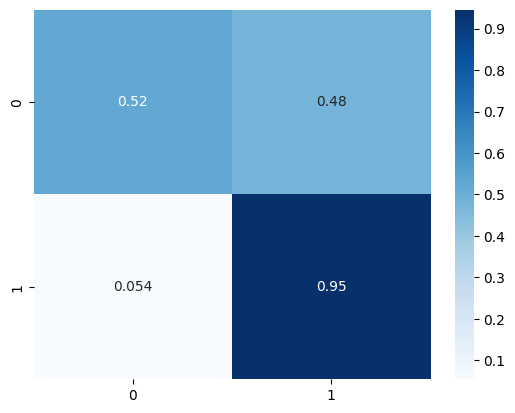

In [16]:
load_path = hps["save_path"]+hps["model"]+".pt"
test(test_loader, load_model(load_path, res))

In [ ]:
# print(history)

In [ ]:
# # history
# history = {"18_train_loss": [], "18_train_acc": [], "18_test_loss": [], "18_test_acc": [],
#           "50_train_loss": [], "50_train_acc": [], "50_test_loss": [], "50_test_acc": [],
#           "152_train_loss": [], "152_train_acc": [], "152_test_loss": [], "152_test_acc": []}

# history["18_train_acc"] = [0.774261474609375, 0.8069995641708374, 0.8114848732948303, 0.805612325668335, 0.8205164074897766, 0.8204954266548157, 0.8256007432937622, 0.8234085440635681, 0.8265928030014038, 0.8328562378883362]
# history["18_test_acc"] = [0.614363968372345, 0.6852965354919434, 0.7076274752616882, 0.3815438449382782, 0.3171074092388153, 0.7520986199378967, 0.3189293444156647, 0.6828926801681519, 0.6925080418586731, 0.49219706654548645]
# history["50_train_acc"] = [0.736666738986969, 0.7856250405311584, 0.784083366394043, 0.7877500653266907, 0.7865000367164612, 0.7929167151451111, 0.765583336353302, 0.7921667098999023, 0.7951667308807373, 0.7987917065620422]
# history["50_test_acc"] = [0.6837499737739563, 0.6837499737739563, 0.6837499737739563, 0.7956249713897705, 0.3162499964237213, 0.6881250143051147, 0.7749999761581421, 0.7686607241630554, 0.748035728931427, 0.8068749904632568]
# history["152_train_acc"] = [0.7317408919334412, 0.7755127549171448, 0.7738452553749084, 0.7768467664718628, 0.7856011390686035, 0.7622561454772949, 0.7752626538276672, 0.7863932251930237, 0.7935217618942261, 0.7928964495658875]
# history["152_test_acc"] = [0.6768749952316284, 0.7606250047683716, 0.7993749976158142, 0.6831249594688416, 0.7593749761581421, 0.7574999928474426, 0.7631250023841858, 0.6837499737739563, 0.8018749952316284, 0.7456249594688416]

In [ ]:
# plot(history, hps["n_epochs"])